# Adaptive Estimator Selection for Off-Policy Evaluation

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy
import argparse
import sys
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

torch.set_default_tensor_type(torch.DoubleTensor)

## Params

In [3]:
# hs = [0.25,0.03125]
hs = [x for x in np.logspace(1, 7, num=7, base=0.5)]
# hs = [x for x in np.linspace(0.01, 0.5, 20)]
hs.reverse()
#hs = [0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

FRIENDLY = {'method': 'friendly', 'alpha': 0.7, 'beta': 0.2, 'l': 10}
ADVERSARIAL = {'method': 'adversarial', 'alpha': 0.3, 'beta': 0.2, 'l': 10}
NEUTRAL = {'method': 'neutral', 'alpha': 0., 'beta': 0., 'l': 10}


ns = [10, 30, 100, 300, 1000, 3000]
Replicates = 100
feat_dim=10
act_dim=2
lip=10

## CCB Env

In [4]:
class NNPredictor(object):
    class NNModel(nn.Module):
        def __init__(self,input_dim,output_dim):
            super(NNPredictor.NNModel,self).__init__()
            self.network = nn.Sequential(nn.Linear(input_dim,output_dim,bias=False),
                                         nn.Sigmoid())
        def forward(self,x):
            return (self.network(x))

    def __init__(self, input_dim, output_dim):
        self.model = NNPredictor.NNModel(input_dim, output_dim)
        self.criterion = nn.MSELoss()

    def fit(self, X, y):
        optimizer = optim.Adagrad(self.model.parameters(), lr = 0.1)
        prev_loss = 0.0
        for i in range(5000):
            total_loss = 0.0
            for a in range(y.shape[1]):
                optimizer.zero_grad()
                preds = self.model(torch.tensor(X))
                loss = self.criterion(preds[:,a], torch.tensor(y[:,a]))
                total_loss += loss
                loss.backward()
                optimizer.step()
            if np.mod(i,100) == 0:
                x = total_loss.detach().numpy()
                if np.round(x,3) == np.round(prev_loss,3):
                    break
                prev_loss = x

    def predict(self, x):
        return self.model(torch.tensor(x)).detach().numpy()



class CCBPolicy(object):
    def __init__(self,act_dim,model=None):
        self.model=model
        self.act_dim=act_dim
    
    
    def friendly_soften(self, action, soften_params):
        alpha = soften_params['alpha']
        beta = soften_params['beta']
        n_bins = soften_params['l']
        soft_action = []
        probs = []
        for act in action[0]:
            bin_id = np.ceil(act * n_bins)
            tau_low = (bin_id-1.)/n_bins
            tau_high = bin_id*1./n_bins

            u = np.random.uniform(-0.5, 0.5)
            explore_prob = alpha+beta*u
            if np.random.uniform(0,1) > explore_prob:
                bin_id = np.random.choice(list(set(np.arange(1,n_bins+1))-set([bin_id])))
            chosen_act = np.random.uniform((bin_id-1.)/n_bins,bin_id*1./n_bins)
            soft_action.append(chosen_act)
            
            rho_o = ((1 - explore_prob) * (n_bins/(n_bins - 1)))
            rho_i = (explore_prob * n_bins)
            
            prob_data = {'tau_low': tau_low, 'tau_high': tau_high, 'rho_o': rho_o, 'rho_i': rho_i}
            probs.append(prob_data)
            
        return soft_action, probs

    def adversarial_soften(self, action, soften_params):
        alpha = soften_params['alpha']
        beta = soften_params['beta']
        n_bins = soften_params['l']
        soft_action = []
        probs = []
        for act in action[0]:
            """
            1. tau_low and tau_high are the lower and upper bounds of the bin in 
            which the unsoftened action falls.
            2. rho_o is the density outside (tau_low, tau_high) after softening
            and rho_i is the density inside (tau_low, tau_high) after softening
            """

            bin_id = np.ceil(act * n_bins)
            tau_low = (bin_id-1.)/n_bins
            tau_high = bin_id*1./n_bins
            
            u = np.random.uniform(-0.5, 0.5)
            explore_prob = alpha+beta*u
            if np.random.uniform(0,1) < alpha+beta*u:
                bin_id = np.random.choice(list(set(np.arange(1,n_bins+1))-set([bin_id])))
            else:
                bin_id = np.random.choice(list(set(np.arange(1,n_bins+1))))
            chosen_act = np.random.uniform((bin_id-1.)/n_bins, bin_id*1./n_bins)
            soft_action.append(chosen_act)
            
            rho_o = (explore_prob * (n_bins/(n_bins - 1))) + (1-explore_prob)
            rho_i = (1 - explore_prob)
            
            prob_data = {'tau_low': tau_low, 'tau_high': tau_high, 'rho_o': rho_o, 'rho_i': rho_i}
            probs.append(prob_data)
            
        return soft_action, probs
    
    def neutral_soften(self, action, soften_params):
        soft_action = np.random.uniform(0,1,[1,self.act_dim])[0]
        probs = []
        for i in range(self.act_dim):
            prob_data = {'tau_low': 0, 'tau_high': 1, 'rho_o': 0, 'rho_i': 1}
            probs.append(prob_data)
        return soft_action, probs
    
    def get_soften_action(self, action, soften_params):
        if soften_params != None:
            soft_action = []
            if soften_params['method'] == "friendly":
                soft_action, probs = self.friendly_soften(action, soften_params)
            elif soften_params['method'] == "adversarial":
                soft_action, probs = self.adversarial_soften(action, soften_params)
            elif soften_params['method'] == "neutral":
                soft_action, probs = self.neutral_soften(action, soften_params)
            return {"action": [soft_action], "prob": probs}
        else:
            probs = []
            for i in range(self.act_dim):
                prob_data = {'tau_low': 0, 'tau_high': 1, 'rho_o': 0, 'rho_i': 1}
                probs.append(prob_data)
            return {"action": action, "prob": probs}

    def get_action(self, x, soften=None):
        
        if soften == "friendly":
            soften_params = FRIENDLY
        elif soften == "adversarial":
            soften_params = ADVERSARIAL
        elif soften == "neutral":
            soften_params = NEUTRAL
        else:
            soften_params = None
            
        if self.model is None:
            act = np.random.uniform(0,1,[1,self.act_dim])
        else:
            if self.act_dim == 1:
                act = self.model.predict(x).reshape(-1,1)
            else:
                act = self.model.predict(x)
            act = torch.clamp(torch.Tensor(act),0,1).detach().numpy()
        act_prob = self.get_soften_action(act, soften_params)
        return act_prob

class CCBSimulatedEnv(object):
    def __init__(self, lip=1, feat_dim=5, act_dim = 1, target_model_name = "NNPredictor", logging_model_name = None, loss_type="triangular", soften=None):
        self.feat_dim=feat_dim
        self.act_dim=act_dim
        self.logging_model = self.get_model(logging_model_name)
        self.target_model = self.get_model(target_model_name)
        self.lip=lip
        self.opt=np.random.normal(0,1,(self.feat_dim,self.act_dim))
        self.loss_type = loss_type
        self.soften=soften

    def get_model(self, model_name):
        if model_name == "NNPredictor":
            return NNPredictor(self.feat_dim,self.act_dim)
        elif model_name == "Tree":
            #return DecisionTreeRegressor(max_depth=5, min_samples_split = 5, min_samples_leaf = 5)
            return RandomForestRegressor(random_state=1, n_estimators=10, min_samples_split=5)
        else:
            return None
        
    def train_logger(self, n=0, sig=0.5):
        """
        Uniform logging policy for now
        """
        if self.soften:
            if self.logging_model != None:
                X = np.zeros((n, self.feat_dim))
                Y = np.zeros((n, self.act_dim))
                for i in range(n):
                    x = self.context()
                    X[i,:] = x
                    Y[i,:]= self.get_center(x) + np.random.normal(0,sig,(1,self.act_dim))
        
                self.logging_model.fit(X,Y)
            else:
                raise ValueError("soften without model?!! can't do!!!")
            self.logger = CCBPolicy(self.act_dim, model = self.logging_model)
        else:
            self.logger = CCBPolicy(self.act_dim)

    def train_target(self, n,sig=0.5):
        """
        Good target policy trained via logistic regression (effectively)
        """
        X = np.zeros((n, self.feat_dim))
        Y = np.zeros((n, self.act_dim))
        for i in range(n):
            x = self.context()
            X[i,:] = x
            Y[i,:]= self.get_center(x) + np.random.normal(0,sig,(1,self.act_dim))

        self.target_model.fit(X,Y)
        self.target = CCBPolicy(self.act_dim,model=self.target_model)

    def ground_truth(self,n):
        '''
        if self.soften == "friendly":
            soften_params = FRIENDLY
        elif self.soften == "adversarial":
            soften_params = ADVERSARIAL
        elif self.soften == "neutral":
            soften_params = NEUTRAL
        else:
            soften_params = None'''
        soften_params = None
        l = 0
        for i in range(n):
            x = self.context()
            a = self.target.get_action(x,soften_params)['action']
            l += self.loss(x,a)
        return(l/n)

    def get_center(self,x):
        return np.exp(np.dot(x,self.opt))/(1+np.exp(np.dot(x,self.opt)))

    def loss(self, x, a):
        center = self.get_center(x)
        if self.loss_type == "triangular":
            loss = min(np.sum(self.lip*np.abs(a - center)),1)
        elif self.loss_type == "parabolic":
            loss = min(np.sum((self.lip**2/4)*np.abs(a-center)),1)
        else:
            loss = 1.
        return loss

    def context(self):
        x = np.random.normal(0,1,[1,self.feat_dim])
        return(x)

    def gen_logging_data(self,n):
        """
        @akshay: only supports uniform logging for now
        """
        data = []
        for i in range(n):
            x = self.context()
            act_prob = self.logger.get_action(x, self.soften)
            a = act_prob["action"]
            p = act_prob["prob"]
            #print("prob: ", p)
            l = self.loss(x,a)
            data.append((x,a,l,p))
        return (data)

In [6]:
Env = CCBSimulatedEnv(lip=3,act_dim=2)
Env.train_logger()
Env.train_target(100)
print("Ground truth loss: %0.2f" % (Env.ground_truth(1000)))

data = Env.gen_logging_data(10000)
print("Uniform exploration average loss: %0.2f" % (np.mean([tup[2] for tup in data])))

Ground truth loss: 0.55
Uniform exploration average loss: 0.94


In [ ]:
"""
Env = CCBSimulatedEnv(lip=3, act_dim=2, target_model_name = "NNPredictor", logging_model_name = "NNPredictor")
Env.train_logger(10000)
Env.train_target(3000)
soften_target_params = None
soften_logging_params = {'method': 'friendly', 'alpha': 0.7, 'beta': 0.2, 'l': 10}
print("Ground truth loss: %0.2f" % (Env.ground_truth(100000, soften_target_params)))
data = Env.gen_logging_data(1000, soften_logging_params)
print("Uniform exploration average loss: %0.2f" % (np.mean([tup[2] for tup in data])))
"""

#import SmoothEval
#print("Off policy estimate: %0.2f" % (SmoothEval.smooth_eval(Env.target, data, 0.1)))

## Estimators

In [7]:
class Estimator(object):

    def __init__(self,params=None):
        self.params=params

    def estimate(self,target,data):
        return 0
    
    def variance(self,target,data):
        return 0


class SmoothedEstimator(Estimator):
    def __init__(self,h, soften=False, kernel = None):
        super(Estimator).__init__()
        self.h = h
        self.soften = soften
        self.kernel = kernel
        
    def epanechnikov_kernel(self, u):
        return 0.75*(1-u**2)*(1 if abs(u) <= 1 else 0)

    def epanechnikov_int(self,lo,hi):
        '''
        :return: Definite integral of the kernel from between lo and hi. Assumes that they are within bounds.
        '''
        return 0.75*(hi-hi**3/3.0) - 0.75*(lo-lo**3/3.0)
    
    def boxcar_kernel(self, u):
        return 0.5*(1 if abs(u) <= 1 else 0)
    
    def boxcar_int(self,lo,hi):
        '''
        :return: Definite integral of the kernel from between lo and hi. Assumes that they are within bounds.
        '''
        return abs(hi -lo)/2.
    
    def get_density(self,a,p):
        if a >= p['tau_low'] and a <= p['tau_high']:
            return p['rho_i']
        else:
            return p['rho_o']
        
    def estimate(self,target,data):
        val = 0
        rewards = []
        for tup in data:
            (x,a,l,p) = tup
            target_action = target.get_action(x)['action']
            if self.kernel == None:
                # boundary bias not handled here, experiment at your own risk
                if np.all(np.abs(a - target_action) <= self.h):
                    val += l/self.get_prob(target_action, p)
            elif self.kernel == "epanechnikov":
                den = 1.
                num = l
                for d in range(target_action.shape[1]): 
                    delta = (a[0][d] - target_action[0,d])/self.h
                    num *= self.epanechnikov_kernel(delta)
                    t_lo = max(target_action[0,d]-self.h, -1)
                    t_hi = min(target_action[0,d]+self.h, 1)
                    lo = (t_lo - target_action[0,d])/self.h
                    hi = (t_hi - target_action[0,d])/self.h
                    den *= self.get_density(target_action[0,d],p[d]) * self.h * self.epanechnikov_int(lo, hi)
                val += num/den
                rewards.append(num/den)
            elif self.kernel == "boxcar":
                den = 1.
                num = l
                for d in range(target_action.shape[1]):
                    delta = (a[0][d] - target_action[0,d])/self.h
                    num *= self.boxcar_kernel(delta)
                    t_lo = max(target_action[0,d]-self.h, -1)
                    t_hi = min(target_action[0,d]+self.h, 1)
                    lo = (t_lo - target_action[0,d])/self.h
                    hi = (t_hi - target_action[0,d])/self.h
                    den *= self.get_density(target_action[0,d],p[d]) * self.boxcar_int(lo,hi) * self.h
                val += num/den
                rewards.append(num/den)
        #print("losses ", losses)
        return val/len(data)#, rewards
    
    def interval_overlap(self,sa_l, sa_h, b_l, b_h):
        '''
        Returns how much the interval (sa_l, sa_h) overlaps the interval (b_l, b_h)
        '''
        return max(min(sa_h,b_h)-max(sa_l, b_l), 0)

    def get_prob(self,a,p):
        if self.soften:
            prob = 1.
            for d in range(a.shape[1]):
                part1 = p[d]['rho_o'] * self.interval_overlap(a[0,d]-self.h, a[0,d]+self.h,0, p[d]['tau_low'])
                part2 = p[d]['rho_i'] * self.interval_overlap(a[0,d]-self.h, a[0,d]+self.h, p[d]['tau_low'], p[d]['tau_high'])
                part3 = p[d]['rho_o'] * self.interval_overlap(a[0,d]-self.h, a[0,d]+self.h, p[d]['tau_high'], 1)
                prob *= part1 + part2 + part3
            return prob
        else:
            """
            Get uniform density for the box of length h around a.
            This is complicated due to edge effects
            """
            total = 1
            for d in range(a.shape[1]):
                total *= min(a[0,d]+self.h,1)-max(a[0,d]-self.h,0)
            return total


    def variance(self,target,data):
        mean = 0
        zs = []
        for tup in data:
            (x,a,l,p) = tup
            target_action = target.get_action(x)['action']
            tmp = 0
            if self.kernel == None and np.all(np.abs(a - target_action) <= self.h):
                # boundary biasnot handled here, experiment at your own risk
                tmp = l/self.get_prob(target_action, p)
            elif self.kernel == "epanechnikov":
                den = 1.
                num = l
                for d in range(target_action.shape[1]): 
                    delta = (a[0][d] - target_action[0,d])/self.h
                    num *= self.epanechnikov_kernel(delta)
                    t_lo = max(target_action[0,d]-self.h, -1)
                    t_hi = min(target_action[0,d]+self.h, 1)
                    lo = (t_lo - target_action[0,d])/self.h
                    hi = (t_hi - target_action[0,d])/self.h
                    den *= self.get_density(target_action[0,d],p[d]) * self.h * self.epanechnikov_int(lo, hi)
                tmp += num/den
            elif self.kernel == "boxcar":
                den = 1.
                num = l
                for d in range(target_action.shape[1]):
                    delta = (a[0][d] - target_action[0,d])/self.h
                    num *= self.boxcar_kernel(delta)
                    t_lo = max(target_action[0,d]-self.h, -1)
                    t_hi = min(target_action[0,d]+self.h, 1)
                    lo = (t_lo - target_action[0,d])/self.h
                    hi = (t_hi - target_action[0,d])/self.h
                    den *= self.get_density(target_action[0,d],p[d]) * self.boxcar_int(lo,hi) * self.h
                tmp += num/den
            mean += tmp
            zs.append(tmp)
        mean = mean/len(data)
        return(np.mean([(z-mean)**2 for z in zs])/(len(zs)-1))

## SLOPE

In [9]:
class Slope(Estimator):
    """
    The assumption is that hyperparams is a sequence for which
    variance is decreasing.
    """
    def __init__(self,params=None):
        if params is None:
            raise Exception("Slope requires two parameters")

        self.estimator = None
        self.hyperparams = None
        if 'estimator' in params.keys():
            self.estimator = params['estimator']
        if 'hyperparams' in params.keys():
            self.hyperparams = params['hyperparams']
        if 'soften' in params.keys():
            self.soften = params['soften']
        if 'kernel' in params.keys():
            self.kernel = params['kernel']

        if self.estimator is None or self.hyperparams is None:
            raise Exception("Slope requires base estimator and set of hyperparameters")
        
        self.plot = False
        if 'plot' in params.keys():
            self.plot=True

    def estimate(self,target,data):
        means = []
        widths = []
        for h in self.hyperparams: # assumption: hs are ordered ascending
            E = self.estimator(h, self.soften, self.kernel)
            mean = E.estimate(target,data)
            means.append(mean)
            var = E.variance(target,data)
            widths.append(np.sqrt(var))
        intervals = []
        for i in range(len(self.hyperparams)):
            if i < len(self.hyperparams)-1:
                width = max(widths[i], max(widths[i+1:]))
            else:
                width = widths[i]
            intervals.append((means[i] - 2*width, means[i] + 2*width))
            print("[Slope] h = %0.2f, mean = %0.2f, low = %0.2f, high = %0.2f" % (self.hyperparams[i], means[i], intervals[-1][0], intervals[-1][1]), flush=True) 
        index = 0
        curr = [intervals[0][0], intervals[0][1]]
        for i in range(len(intervals)):
            if intervals[i][0] > curr[1] or intervals[i][1] < curr[0]:
                ### Current interval is not overlapping with previous ones, return previous index
                break
            else:
                ### Take intersection
                curr[0] = max(curr[0], intervals[i][0])
                curr[1] = min(curr[1], intervals[i][1])
                index = i
            print("[Slope] curr_low = %0.2f, curr_high = %0.2f" % (curr[0], curr[1]))
        print("[Slope] returning index %d" % (index), flush=True)
        self.means = means
        self.intervals = intervals
        self.index = index
        return means[index]

[0.00390625 0.0078125  0.015625   0.03125    0.0625     0.125
 0.25       0.5        1.        ]
[Slope] h = 0.00, mean = 0.25, low = -0.04, high = 0.53
[Slope] h = 0.01, mean = 0.28, low = 0.08, high = 0.48
[Slope] h = 0.02, mean = 0.33, low = 0.19, high = 0.47
[Slope] h = 0.03, mean = 0.32, low = 0.22, high = 0.41
[Slope] h = 0.06, mean = 0.38, low = 0.30, high = 0.45
[Slope] h = 0.12, mean = 0.47, low = 0.40, high = 0.53
[Slope] h = 0.25, mean = 0.59, low = 0.54, high = 0.64
[Slope] h = 0.50, mean = 0.68, low = 0.64, high = 0.71
[Slope] h = 1.00, mean = 0.58, low = 0.56, high = 0.60
[Slope] curr_low = -0.04, curr_high = 0.53
[Slope] curr_low = 0.08, curr_high = 0.48
[Slope] curr_low = 0.19, curr_high = 0.47
[Slope] curr_low = 0.22, curr_high = 0.41
[Slope] curr_low = 0.30, curr_high = 0.41
[Slope] curr_low = 0.40, curr_high = 0.41
[Slope] returning index 5
[0.5614697143179493, 0.4058911936714811, 0.27863378956499896, 0.1902802142473463, 0.15564567751178704, 0.1286471679836968, 0.106

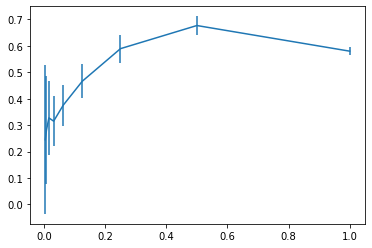

In [21]:
Env = CCBSimulatedEnv(lip=5,act_dim=1)
Env.train_logger()
Env.train_target(100)
hs = np.logspace(-8,0,9,base=2)
print(hs)
n = 1000

data = Env.gen_logging_data(n)
estimator = Slope(params={'estimator':SmoothedEstimator,'hyperparams': hs,
                          'soften':'friendly', 'kernel':'boxcar'})
estimator.estimate(Env.target, data)

print([estimator.intervals[i][1] - estimator.intervals[i][0] for i in range(len(hs))], flush=True)

errors = np.zeros((2,len(hs)))
errors[0,:] = [estimator.means[i] - estimator.intervals[i][0] for i in range(len(hs))]
errors[1,:] = [estimator.intervals[i][1]-estimator.means[i] for i in range(len(hs))]

plt.errorbar(hs, estimator.means, errors)
plt.show()

In [ ]:
def parse_args():
    parser=argparse.ArgumentParser(description='Continuous CB Simulations')
    parser.add_argument('--seed', type=int, default=577, metavar='N',
                        help='random seed (default: 577)')
    parser.add_argument('--start_iter', type=int, default=1,
                        help='Which replicate number to start at')
    parser.add_argument('--total_iter', type=int, default=5,
                        help='Number of iterations')
    parser.add_argument('--feat_dim', type=int, default=5,
                        help='Dimensionality of feature space')
    parser.add_argument('--act_dim', type=int, default=1,
                        help='Dimensionality of action space')
    parser.add_argument('--lip', type=float, default=10,
                        help='Lipschitz constant for losses')
    parser.add_argument('--samples', type=int, default=100,
                        help='Number of samples')
    parser.add_argument('--kernel', type=str, default=None,
                        help='kernel function to use for smoothing: boxcar or epanechnikov')
    parser.add_argument('--soften', type=str, default=None,
                        help='stochastic tranformation for policy: freindly, adversarial, Neutral or None')
    parser.add_argument('--loss', type=str, default='triangular',
                        help='specify loss function: triangular or parabolic')
    parser.add_argument('--logging_model_name', type=str, default=None,
                        help='specify model type for logging policy: NNPredictor or Tree or None')
    parser.add_argument('--target_model_name', type=str, default='NNPredictor',
                        help='specify model type for target policy: NNPredictor or Tree or None')
    parser.add_argument('--command_num', type=int, default=0,
                        help='command line number from commands_list.txt')
    parser.add_argument('--expt_name', type=str, default="slope-results",
                        help='results will be stored in a folder expt_name in azure storage')
    args=parser.parse_args(args={})
    return(args)

In [25]:
Args = parse_args()
print(Args, flush=True)
np.random.seed(Args.seed)
random.seed(Args.seed)
torch.manual_seed(Args.seed)

Env = CCBSimulatedEnv(lip=Args.lip,feat_dim=Args.feat_dim,act_dim=Args.act_dim, target_model_name=Args.target_model_name,logging_model_name=Args.logging_model_name, loss_type=Args.loss, soften = Args.soften)
Env.train_logger(10000)
Env.train_target(100)
ground_truth=Env.ground_truth(100000)
print("ground truth: ", ground_truth)

print("[Experiment] Bandwidths: %s" % (",".join([str(x) for x in hs])), flush=True)
for i in range(Args.start_iter, Args.start_iter+Args.total_iter):
    np.random.seed(Args.seed+37*i)
    random.seed(Args.seed+37*i)
    print("generating logging data")
    data = Env.gen_logging_data(Args.samples)
    mses = []
    mses_dict = {}
    for h in hs:
        #print("\nh ", h)
        estimator = SmoothedEstimator(h, Args.soften, Args.kernel)
        estimate = estimator.estimate(Env.target, data)
        mses.append((estimate-ground_truth)**2)
        mses_dict[h] = mses[-1]
    estimator=Slope(params={'estimator': SmoothedEstimator, 'hyperparams': hs, 'soften': Args.soften, 'kernel':Args.kernel})
    estimate = estimator.estimate(Env.target, data)
    mses.append((estimate-ground_truth)**2)
    mses_dict['slope'] = mses[-1]
    
    
    print({k: v for k, v in sorted(mses_dict.items(), key=lambda item: item[1])}, flush=True)
    f = open('./command_num=%s_replicate=%d.json' % (Args.command_num,i), 'w')
    results = {}
    for j in range(len(hs)):
        results[hs[j]] = mses[j]
    results['Slope'] = mses[-1]
    results['index'] = estimator.index
    results['command_num'] = Args.command_num
    results['replicate'] = i
    results['ground_truth'] = ground_truth
    results['logging_model'] = Args.logging_model_name
    results['target_model'] = Args.target_model_name
    results['soften'] = Args.soften
    results['kernel'] = Args.kernel
    results['lip'] = Args.lip
    results['samples'] = Args.samples
    results['loss'] = Args.loss
    f.write(json.dumps(results))
    f.close()

Namespace(act_dim=1, command_num=0, expt_name='slope-results', feat_dim=5, kernel=None, lip=10, logging_model_name=None, loss='triangular', samples=100, seed=577, soften=None, start_iter=1, target_model_name='NNPredictor', total_iter=5)
ground truth:  0.5671172485946827
[Experiment] Bandwidths: 0.00390625,0.0078125,0.015625,0.03125,0.0625,0.125,0.25,0.5,1.0
generating logging data
[Slope] h = 0.00, mean = 2.22, low = -0.94, high = 5.39
[Slope] h = 0.01, mean = 1.11, low = -0.47, high = 2.69
[Slope] h = 0.02, mean = 0.56, low = -0.24, high = 1.35
[Slope] h = 0.03, mean = 0.54, low = 0.03, high = 1.06
[Slope] h = 0.06, mean = 0.69, low = 0.28, high = 1.10
[Slope] h = 0.12, mean = 0.68, low = 0.36, high = 0.99
[Slope] h = 0.25, mean = 0.74, low = 0.51, high = 0.98
[Slope] h = 0.50, mean = 0.75, low = 0.60, high = 0.91
[Slope] h = 1.00, mean = 0.89, low = 0.84, high = 0.94
[Slope] curr_low = -0.94, curr_high = 5.39
[Slope] curr_low = -0.47, curr_high = 2.69
[Slope] curr_low = -0.24, curr_h

In [14]:
i = 0
f = open('commands.sh', 'w')
for logging_model_name in ["NNPredictor", "Tree"]:
    for target_model_name in ["NNPredictor", "Tree"]:
        for soften in ["friendly", "adversarial"]:
            for kernel in ["boxcar"]:
                for loss in ["triangular"]:
                    for lip in [0.1, 1, 10]:
                        for samples in [10,100,1000]:
                            f.write("python3 ./src/Experiment.py --logging_model_name "+str(logging_model_name)+" --target_model_name "+str(target_model_name)+" --soften "+str(soften)+" --kernel "+str(kernel)+" --loss "+str(loss)+" --lip "+str(lip)+" --samples "+str(samples)+" --command_num "+str(i)+"\n")
                            i+=1
f.close()

In [15]:
!cat commands.sh

python3 ./src/Experiment.py --logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 0.1 --samples 10 --command_num 0
python3 ./src/Experiment.py --logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 0.1 --samples 100 --command_num 1
python3 ./src/Experiment.py --logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 0.1 --samples 1000 --command_num 2
python3 ./src/Experiment.py --logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 1 --samples 10 --command_num 3
python3 ./src/Experiment.py --logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 1 --samples 100 --command_num 4
python3 ./src/Experiment.py --logging_model_name NNPredictor --target_model_name

In [26]:
f = open('commands_list_test.txt', 'w')
for logging_model_name in ["NNPredictor", "Tree"]:
    for target_model_name in ["NNPredictor", "Tree"]:
        for soften in ["friendly", "adversarial"]:
            for kernel in ["boxcar", "epanechnikov"]:
                for loss in ["triangular", "parabolic"]:
                    for lip in [1, 3, 10]:
                        for samples in [100,1000,10000,100000]:
                            f.write("--logging_model_name "+str(logging_model_name)+" --target_model_name "+str(target_model_name)+" --soften "+str(soften)+" --kernel "+str(kernel)+" --loss "+str(loss)+" --lip "+str(lip)+" --samples "+str(samples)+"\n")
f.close()

f = open('commands_list_test.txt', 'a')
for logging_model_name in ["NNPredictor", "Tree"]:
    for target_model_name in ["NNPredictor", "Tree"]:
        for loss in ["triangular", "parabolic"]:
            for lip in [1, 3, 10]:
                for kernel in ["boxcar", "epanechnikov"]:
                    for samples in [100,1000,10000,100000]:
                        f.write("--logging_model_name "+str(logging_model_name)+" --target_model_name "+str(target_model_name)+" --loss "+str(loss)+" --lip "+str(lip)+" --samples "+str(samples)+" --kernel "+str(kernel)+"\n")
f.close()

In [27]:
!cat commands_list_test.txt

--logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 1 --samples 100
--logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 1 --samples 1000
--logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 1 --samples 10000
--logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 1 --samples 100000
--logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 3 --samples 100
--logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 3 --samples 1000
--logging_model_name NNPredictor --target_model_name NNPredictor --soften friendly --kernel boxcar --loss triangular --lip 3 --samples 10000
--logging_model_na

## Plot JSON

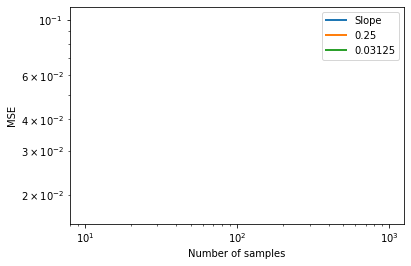

In [33]:
# commands = [0,1,2,3,4,5,6,7,8,9]
# iters = 100

commands = [0]
iters = 6


data_dict = {
    'Slope': [],
    '0.25': [],
    '0.03125': [],
    }

K = [
'Slope', 
'0.25', 
'0.03125']
ns = []

data = {
    
    }

for c in commands:
    for i in range(1,iters):
        x = json.loads(open('./command_num=%d_replicate=%d.json' % (c, i), 'r').readlines()[0])
        n = x['samples']
        if n not in data.keys():
            data[n] = copy.deepcopy(data_dict)
            ns.append(n)
        for k in K:
            data[n][k].append(x[k])

ns.sort()

fig = plt.figure()
ls = []
for k in K:
    x = np.array([np.mean(data[n][k]) for n in ns])
    z = np.array([np.std(data[n][k]) for n in ns])
    ls.append(plt.plot(ns, x,linewidth=2))
    plt.fill_between(ns, x - 2/np.sqrt(iters)*z, x + 2/np.sqrt(iters)*z,alpha=0.2)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('MSE')
ax.set_xlabel('Number of samples')

K[K.index('Slope')] = 'Slope'
plt.legend(K)

plt.savefig('./cb_learning_curve.pdf', format='pdf', dpi=100,bbox_inches='tight')
plt.show()